In [1]:
import tensorflow as tf
tf.random.set_seed(42)
from kerasbeats import prep_time_series, NBeatsModel
from tensorflow import keras
import numpy as np
import pandas as pd


def create_nbeat_mlp(num_columns, num_labels, lookback, horizon, hidden_units, dropout_rates, batch_size, ls=1e-2, lr=1e-3, ):
    nbeats = NBeatsModel(model_type = 'generic', lookback = lookback, horizon = horizon,
                         learning_rate = lr, batch_size = batch_size,
                         num_generic_neurons = hidden_units[0]) # set as default
    nbeats.build_layer()
    time_input = keras.layers.Input(shape = (lookback * horizon, ))
    x_nb = nbeats.model_layer(time_input)

    xcons = keras.layers.Input(shape = (num_columns, ))
    x = keras.layers.Concatenate()([xcons, x_nb])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)

    for i in range(1, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i])(x)

    out = tf.keras.layers.Dense(num_labels, name = 'action')(x)
    model = tf.keras.models.Model(inputs = [time_input, xcons], outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss = {'action' : tf.keras.losses.MeanSquaredError()},
                  metrics = {'action' : tf.metrics.MeanSquaredError(name = 'mse')})
    return model

2023-12-03 01:04:19.075189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from itertools import islice
import tscv

def generate_label(df, threshold = 0.002):
    df['label'] = 0
    df.loc[(df['target_15m'] <= -1*threshold), 'label'] = 1
    df.loc[(df['target_15m'] >= threshold), 'label'] = 2
    return df

def get_na_features(df, train_features):
    tmp = pd.DataFrame(df[train_features].isnull().sum())
    tmp = tmp[tmp[0] > 0].reset_index()
    tmp.columns = ['feat', 'cnt']
    tmp = tmp.sort_values('cnt')
    feat_groups = dict(tmp.groupby('cnt')['feat'].agg(lambda x: list(x)))
    return feat_groups

In [3]:
def normalize_columns_infer(df, means, stds):
    features = means.index.tolist()
    for feature in features:
        mean = means.loc[feature]
        std = stds.loc[feature]
        df[feature] = (df[feature] - mean) / std
    return df

In [5]:
train = False
df = pd.read_feather('../data/df_btc_with_features_1m_spot.feather')

df = df.loc[df['token'] == 'BTCUSDT'].reset_index(drop = True)

df = df.sort_values(by='open_time', ignore_index=True)

df['close_5m'] = df['close'].shift(-1)
df['close_t'] = df['close'].copy()
df['target_5m'] = df['close'].pct_change(1)

start_time = df['open_time'].min()
end_time = df['open_time'].max()
dates = df['open_time'].unique()
n = len(dates)
train_idx = int(0.7 * n)
valid_idx = int(0.9 * n)
train_end = dates[train_idx]
valid_end = dates[valid_idx]

train_df = df.loc[df['open_time'] < train_end].reset_index(drop=True)
valid_df = df.loc[(train_end <= df['open_time']) & (df['open_time'] < valid_end)].reset_index(drop=True)

train_df = pd.concat([train_df, valid_df], axis = 0)

test_df = df.loc[(df['open_time'] >= valid_end)].reset_index(drop=True)

valid_df = test_df.copy()

groups = pd.factorize(
    train_df['open_time'].dt.day.astype(str) + '_' + train_df['open_time'].dt.month.astype(str) + '_' + train_df[
        'open_time'].dt.year.astype(str))[0]

cv = tscv.PurgedGroupTimeSeriesSplit(
    n_splits=5,
    group_gap=31,
)

from joblib import load, dump
date = f'11_27'
directory = f'spot_data_1202_nbeats_1m'
lookback = 3
horizon = 500

means = load(f'../output/{directory}/means_nbeats_huber_l=3_h=500_50feats.joblib')
std = load(f'../output/{directory}/std_return_nbeats_l=3_h=500_50feats.joblib')
train_features_test = load(
    f'../output/{directory}/train_features_test_return_nbeats_l=3_h=500_50feats.joblib')

batch_size = 4096
train_features_test += ['target_5m']
params = {'num_columns': len(train_features_test),
          'num_labels': 500,
          'lookback' : lookback,
          'horizon' : horizon,
          'batch_size' : batch_size,
          'hidden_units': [200, 200, 300, 256],
          'dropout_rates': [0.7, 0.5,
                            0.7, 0.5],
          'ls': 0,
          'lr': 1e-3,
          }

valid_df = normalize_columns_infer(valid_df, means, std)

x_val, y_val = prep_time_series(valid_df['target_5m'], lookback = lookback, horizon = horizon)
cutoff_val = valid_df.shape[0] - x_val.shape[0]

x_val_cons = valid_df[train_features_test].iloc[(lookback * horizon) - 1:-horizon, :]
print(f'Shape of X_const is {x_val_cons.shape}, x_tr is {x_val.shape}, y_tr is {y_val.shape}')
fold = 4
model = create_nbeat_mlp(**params)
model.load_weights(f'../output/{directory}/NBEATS_HUBER_4_returns500m_3m_weightedmse_allfeats_hidrop.hdf5')

preds = model.predict([x_val, x_val_cons])


Shape of X_const is (327745, 51), x_tr is (327745, 1500), y_tr is (327745, 500)
10243/10243 [==============================] - 256s 25ms/step


In [11]:
x_val_cons = valid_df[['close_t', 'close_5m', 'open_time', 'target_5m']]

In [7]:
x_time, y_time = prep_time_series(valid_df['open_time'], lookback = lookback, horizon = horizon)

In [8]:
x_val, y_val = prep_time_series(valid_df['target_5m'], lookback = lookback, horizon = horizon)

In [9]:
x_val_price, y_val_price = prep_time_series(valid_df['close_t'], lookback = lookback, horizon = horizon)

In [16]:
tt = x_val_cons.loc[(x_val_cons['open_time'] >= '2023-04-15') & (x_val_cons['open_time'] < '2023-04-16')]

In [12]:
from tqdm import tqdm
ypred = []
ytrue = []
dates = []
ret_pred = []
ret_true = []
for i, row in tqdm(x_val_cons.iterrows()):
    rets = preds[i, :]
    cum_rets = (1 + rets).cumprod() - 1
    prices = (1 + cum_rets) * row['close_t']
    dates.append(row['open_time'])
    ypred.append(prices)
    ytrue_price = y_val_price[i, :]
    ytrue.append(ytrue_price)
    ret_pred.append(rets)
    ytrue_ret = y_val[i, :]
    ret_true.append(ytrue_ret)

327745it [00:30, 10889.77it/s]


IndexError: index 327745 is out of bounds for axis 0 with size 327745

In [13]:
def calculate_weighted_rmse(predictions: np, actual: np) -> float:
    predictions = np.array(predictions)
    actual = np.array(actual)

    k = 0.001

    weights = np.exp(-k * np.arange(len(predictions)))
    weighted_squared_errors = weights * (predictions - actual) ** 2
    weighted_rmse = np.sqrt(np.sum(weighted_squared_errors) / np.sum(weights))

    return weighted_rmse

In [18]:
from sklearn.metrics import r2_score
from tqdm import tqdm

rmse = []
rsquare = []
rmse_5min = []
for i in tqdm(range(1, len(ypred))):
    date = dates[i]
    ypred_price_i = ypred[i]
    ytrue_price_i = ytrue[i]
    ytrue_ret_i = ret_true[i]
    ypred_ret_i = ret_pred[i]
    score = calculate_weighted_rmse(ytrue_price_i, ypred_price_i)
    rmse_5min_score = calculate_weighted_rmse(ytrue_price_i[::5], ypred_price_i[::5])
    rsquare_score = r2_score(ytrue_ret_i, ypred_ret_i)
    rmse.append((date, score))
    rmse_5min.append(rmse_5min_score)
    rsquare.append((date, rsquare_score))

100%|██████████| 327744/327744 [02:26<00:00, 2232.93it/s]


In [19]:
rmse_df = pd.DataFrame(rmse)
rsquared_df = pd.DataFrame(rsquare)
rmse_df_5min = pd.DataFrame(rmse_5min)
# pred_df = pd.DataFrame(ypred)
# true_df = pd.DataFrame(ytrue)

In [20]:
rmse_df_5min.mean()

0    434.587161
dtype: float64

In [21]:
rmse_df.mean()

0    2023-08-06 19:28:29.999998976
1                       433.079244
dtype: object

In [20]:
rmse_df.std()

0    65 days 12:05:19.314835846
1                    175.214985
dtype: object

In [281]:
tt = rmse_df.loc[('2023-10-26' <= rmse_df[0]) & ('2023-10-27' > rmse_df[0])]

In [215]:
sample = pd.DataFrame({
    'ypred' : ypred[55540],
    'ytrue' : ytrue[55540]
})

In [216]:
sample

,ypred,ytrue
0,31551.136719,31521.07
1,31574.626953,31551.50
2,31586.687500,31600.81
3,31564.462891,31629.32
4,31567.626953,31613.31
...,...,...
95,31741.500000,34475.99
96,31738.015625,34514.07
97,31742.509766,34572.01
98,31769.808594,34472.88


<Axes: >

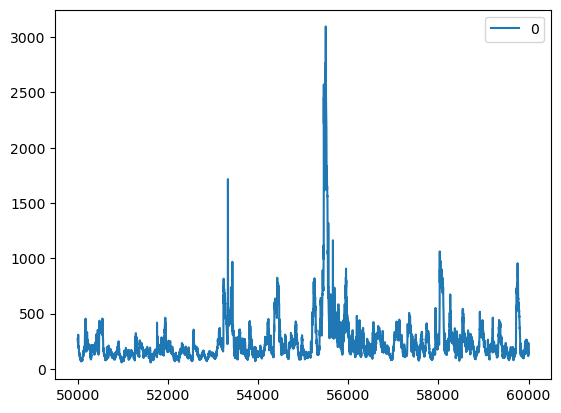

In [67]:
rmse_df.loc[50000:60000].plot()

<Axes: >

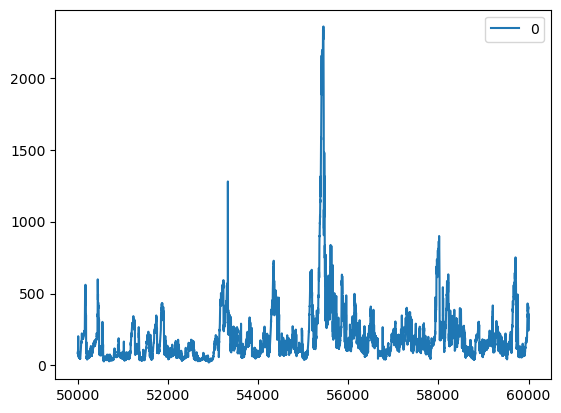

In [30]:
rmse_df.loc[50000:60000].plot()

In [72]:
test_x = x_val[-1, :].reshape(1, -1)
test_x_cons = valid_df[train_features_test].iloc[-1, :].values.reshape(1, -1)

In [78]:
preds = model.predict([test_x, test_x_cons])


1/1 [==============================] - 0s 29ms/step


In [79]:
test_df

array([[-2.7423457e-04],
       [-2.3064767e-03],
       [-1.4398299e-03],
       [-1.3466255e-04],
       [-6.1064749e-04],
       [-1.0027986e-03],
       [ 1.5606404e-03],
       [ 2.3287081e-04],
       [ 7.3816400e-04],
       [-3.8709759e-04],
       [-3.4602184e-04],
       [-8.0463884e-04],
       [-1.0930328e-03],
       [-5.1470066e-04],
       [-1.9291659e-03],
       [-5.9225300e-04],
       [-9.9845883e-04],
       [-7.2583638e-04],
       [ 2.5094178e-04],
       [-5.6439487e-04],
       [-2.5192969e-03],
       [ 1.7120889e-04],
       [-3.9061165e-04],
       [ 1.5866286e-03],
       [ 5.5073638e-04],
       [-1.1011825e-03],
       [ 1.2349584e-03],
       [ 3.5656849e-06],
       [ 8.2784583e-04],
       [-5.6279369e-04],
       [-3.0728395e-04],
       [ 9.1687473e-04],
       [-4.0490413e-05],
       [ 3.9559440e-05],
       [ 2.9032512e-04],
       [-2.7043046e-05],
       [-4.9188617e-05],
       [ 9.6712151e-04],
       [ 6.1888609e-04],
       [-1.4302582e-03],


In [76]:
rmse_df.mean(axis = 0)

0    166.624309
dtype: float64

In [ ]:
x_val, y_val = prep_time_series(valid['close'], lookback = lookback, horizon = horizon)
cutoff_val = valid_df.shape[0] - x_val.shape[0]

In [83]:
x_pred, y_pred = prep_time_series(valid_df['close'], lookback = lookback, horizon = horizon)

In [84]:
x_true, y_true = prep_time_series(valid_df['close_5m'], lookback = lookback, horizon = horizon)

In [97]:
rmse_baseline = []
for row in tqdm(range(valid_df.shape[0]-100)):
    ypred = [valid_df['close'].iloc[row]] * 100
    ytrue = valid_df['close_5m'].iloc[row:row + 100]
    score = calculate_weighted_rmse(ypred, ytrue)
    rmse_baseline.append(score)

100%|██████████| 65649/65649 [00:06<00:00, 10560.92it/s]


In [98]:
rmse_base_df = pd.DataFrame(rmse_baseline, columns = ['baseline'])

In [100]:
rmse_base_df

,baseline
0,65.216209
1,66.619421
2,66.190923
3,64.714689
4,63.573939
...,...
65644,835.754484
65645,695.870742
65646,713.182356
65647,689.329160
